In [1]:
import os
os.chdir('/home/jagust/dino/surf')
from surf import *
% matplotlib inline

In [2]:
matches = np.load('/home/jagust/dino/surf/matches.npy')
order = np.load('/home/jagust/dino/surf/simulation_trials/order_or_removals.npy')

In [29]:
def find_subsess(s):
    ''' Given a path or string, finds the subuject's subsession'''

    inds = re.search('B[0,1,9]\d-\d\d\d_\d\d\d\d-\d\d-\d\d', s)
    if inds is None:
        print 'Subject ID not found'
        return None
    else:
        inds = inds.span()
        return s[inds[0]: inds[1]]

def dampen(g, nodes, cost = 0.5):
    for node in nodes:
        for edge in g.edges(node, data=True):
            edge[2]['weight'] *= cost
    add_distance_attr(g)
    
def run_simulation(fnet, order):
    sp, mod = [], []
    removed = set([])
    for rem in order:
        removed.add(rem)
        dampen(fnet, removed, 0.75)
        # Efficiency
        sp.append(1.0 / nx.average_shortest_path_length(fnet, weight='distance'))
        
        # Modularity
        l = wmd.LouvainCommunityDetection(fnet)
        p = l.run()
        mod.append(p[-1].modularity())
    return sp, mod

def load_graph(path):
    if type(path) == str or type(path) == unicode:
        g = nx.Graph(np.load(path))
        add_distance_attr(g)
    else:
        g = nx.Graph(path)
        add_distance_attr(g)
    return g

def find_modularity(fnet):
    l = wmd.LouvainCommunityDetection(fnet)
    p = l.run()
    return p[-1].modularity()

In [23]:
neg_mat = np.absolute(np.load('/home/jagust/dino/surf/mats/ignore_pib_pos/neg_med_mat.npy'))
pos_mat = np.absolute(np.load('/home/jagust/dino/surf/mats/ignore_pib_pos/pos_med_mat.npy'))

neg_g = load_graph(neg_mat)
pos_g = load_graph(pos_mat)

In [24]:
neg_res = run_simulation(neg_g.copy(), order)
pos_res = run_simulation(pos_g.copy(), order)

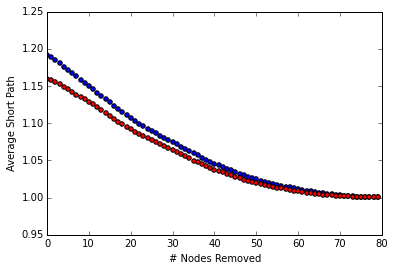

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(80), pos_res[0], c = 'b')
ax.scatter(range(80), neg_res[0], c = 'r')
plt.xlim(0, 80)
plt.ylabel('Average Short Path')
plt.xlabel('# Nodes Removed')

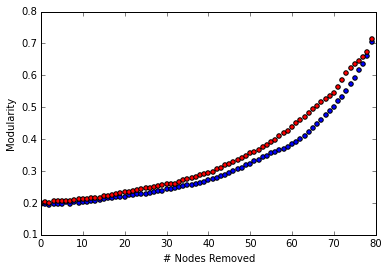

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(80), pos_res[1], c = 'b')
ax.scatter(range(80), neg_res[1], c = 'r')
plt.xlim(0, 80)
plt.ylabel('Modularity')
plt.xlabel('# Nodes Removed')

[{1, 2, 3, 8, 10, 11, 21, 54},
 {5, 6, 25},
 {9, 17, 18, 20, 26, 29, 37, 44, 47, 50, 53, 59, 77},
 {0, 7, 15, 28, 36, 38, 39, 43, 48, 62, 64, 69, 71, 72, 76},
 {61, 67},
 {13, 23, 30, 31, 51, 56, 58, 63, 70},
 {4, 16, 22, 24, 32, 34, 35, 42, 49, 55, 57, 65},
 {33, 66, 68, 75},
 {12, 14, 19, 27, 40, 41, 45, 46, 52, 60, 73, 74, 78, 79}]

In [33]:
master_subject_path = "/home/jagust/dino/graph/data/mri1.5/rest/master_subject_summary.xlsx"
subject_summary = pd.ExcelFile(master_subject_path).parse("Sheet1")
subject_summary[subject_summary.Subsess == 'B05-201_2009-03-27'].values[0][3]

75.0

In [131]:
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])

    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
        
    pos_g = load_graph(util.threshold_adjacency_matrix(np.load((match[0])), cost = 0.30)[0])
    neg_g = load_graph(util.threshold_adjacency_matrix(np.load((match[1])), cost = 0.30)[0])
        
#     pos_g = load_graph(np.load((match[0])))
#     neg_g = load_graph(np.load((match[1])))
    
#     remove_neg_weights(pos_g)
#     remove_neg_weights(neg_g)

#     pos_g = load_graph(np.absolute(np.load((match[0]))))
#     neg_g = load_graph(np.absolute(np.load((match[1]))))
    
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])

#     pos_met.append(find_modularity(pos_g))
#     neg_met.append(find_modularity(neg_g))
    
#     pos_met.append(nx.average_clustering(pos_g) / nx.average_shortest_path_length(pos_g))
#     neg_met.append(nx.average_clustering(neg_g) / nx.average_shortest_path_length(neg_g))
    pos_met.append(sum(nx.communicability_centrality_exp(pos_g).values()))
    neg_met.append(sum(nx.communicability_centrality_exp(neg_g).values()))

#     neg_res = run_simulation(neg_g.copy(), order)
#     pos_res = run_simulation(pos_g.copy(), order)
    
#     np.save('/home/jagust/dino/surf/simulation_trials/ignore_pib_pos/%s.npy' % pos_id, np.array(pos_res))
#     np.save('/home/jagust/dino/surf/simulation_trials/ignore_pib_pos/%s.npy' % neg_id, np.array(neg_res))

E4+     r: (0.21917273800888967, 0.30348776068730865)
E4-     r: (-0.049427343163316664, 0.81859158200564619)


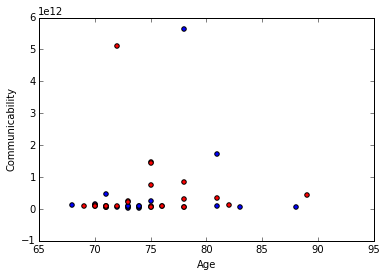

In [132]:
# Binary Graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
plt.ylabel('Communicability')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

E4+     r: (0.027458851672377098, 0.89865329252804893)
E4-     r: (0.12381668832786992, 0.56433156763496239)


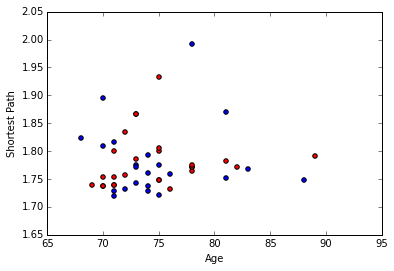

In [72]:
# Binary Graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
plt.ylabel('Shortest Path')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

E4+     r: (0.049600791531000908, 0.81796536087725069)
E4-     r: (0.24926893513142154, 0.24014322676711336)


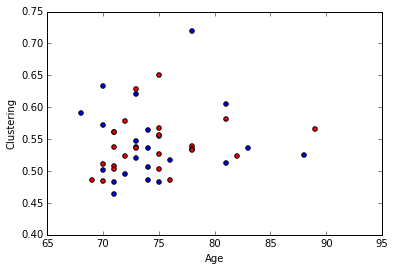

In [75]:
# Binary Graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
plt.ylabel('Clustering')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

E4+     r: (0.059440842834703717, 0.78262643687769962)
E4-     r: (0.31243332957989839, 0.13717405508146729)


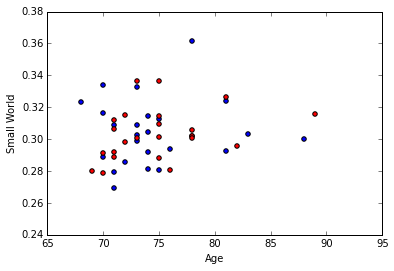

In [82]:
# Binary Graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
plt.ylabel('Small World')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

E4+     r: (0.12927870406827593, 0.54713463833334064)
E4-     r: (-0.11169296330272731, 0.60334122822326441)


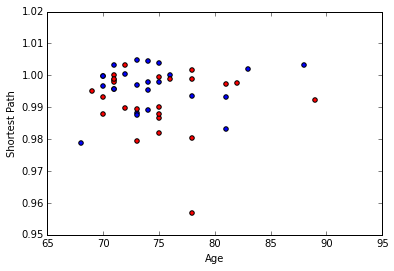

In [59]:
# Weighted Graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
plt.ylabel('Shortest Path')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

E4+     r: (0.109103379463706, 0.61181721061852246)
E4-     r: (0.10049586748319971, 0.64033472137171565)


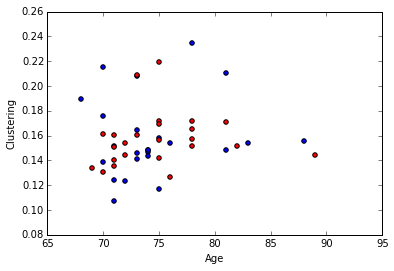

In [62]:
# Absolute Value Graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
plt.ylabel('Clustering')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

E4+     r: (0.10527424122509284, 0.62443920142711828)
E4-     r: (0.090845467070606811, 0.67290349722358367)


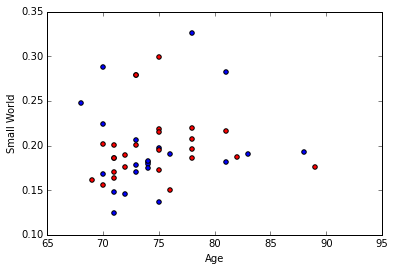

In [52]:
# Absolute Value Graph
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
plt.ylabel('Small World')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

E4+     r: (-0.092048470567915819, 0.66881076263623895)
E4-     r: (-0.081433720655078742, 0.70522676573391307)


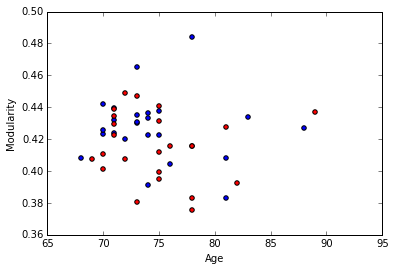

In [66]:
# Removed Negative Weights
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
plt.ylabel('Modularity')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

In [122]:
print "Communicability Centrality"
for reg in range(80):
    pos_age, neg_age, pos_met, neg_met = [], [], [], []
    for match in matches:
        pos_id = find_subsess(match[0])
        neg_id = find_subsess(match[1])
        if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
            continue
        pos_g = load_graph(util.threshold_adjacency_matrix(np.load((match[0])), cost = 0.30)[0])
        neg_g = load_graph(util.threshold_adjacency_matrix(np.load((match[1])), cost = 0.30)[0])
#         pos_g = load_graph(np.load((match[0])))
#         neg_g = load_graph(np.load((match[1])))
    #     remove_neg_weights(pos_g)
    #     remove_neg_weights(neg_g)
#         pos_g = load_graph(np.absolute(np.load((match[0]))))
#         neg_g = load_graph(np.absolute(np.load((match[1]))))
        pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
        neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
#         pos_met.append(nx.average_clustering(pos_g))
#         neg_met.append(nx.average_clustering(neg_g))
#         pos_met.append(nx.average_clustering(pos_g, weight = 'weight') / nx.average_shortest_path_length(pos_g, weight = 'distance'))
#         neg_met.append(nx.average_clustering(neg_g, weight = 'weight') / nx.average_shortest_path_length(neg_g, weight = 'distance'))

        pos_met.append(nx.communicability_centrality_exp(pos_g).values()[reg])
        neg_met.append(nx.communicability_centrality_exp(neg_g).values()[reg])
        
    rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
    if rp[1] < 0.05 or rn[1] < 0.05:
        print str(reg)
        print rp
        print rn

    #     pos_met.append(find_modularity(pos_g))
    #     neg_met.append(find_modularity(neg_g))

#         pos_met.append(nx.average_clustering(pos_g) / nx.average_shortest_path_length(pos_g))
#         neg_met.append(nx.average_clustering(neg_g) / nx.average_shortest_path_length(neg_g))


#         pos_met.append(nx.average_clustering(pos_g))
#         neg_met.append(nx.average_clustering(neg_g))

#         pos_met.append(nx.average_shortest_path_length(pos_g))
#         neg_met.append(nx.average_shortest_path_length(neg_g))

    #     neg_res = run_simulation(neg_g.copy(), order)
    #     pos_res = run_simulation(pos_g.copy(), order)

    #     np.save('/home/jagust/dino/surf/simulation_trials/ignore_pib_pos/%s.npy' % pos_id, np.array(pos_res))
    #     np.save('/home/jagust/dino/surf/simulation_trials/ignore_pib_pos/%s.npy' % neg_id, np.array(neg_res))
# Tried bc but wouldn't survive m.c. correction
# Tried degree but wouldn't survive m.c. correcation

Communicability Centrality
4
(0.31143391591358011, 0.13850262856695561)
(0.57619414997180107, 0.0032107981667558734)
8
(0.2108554657028246, 0.32265798701736542)
(0.41637374850220205, 0.042982335850870294)
11
(0.19087233515930296, 0.37163476475603408)
(0.64902561070184139, 0.000600957069905583)
20
(0.24974330753981394, 0.23922024569693148)
(0.50324350112411431, 0.012184036497586903)
22
(0.23163227602401348, 0.27611830114065394)
(0.50621542681910403, 0.011602887954342896)
26
(0.20949411310316293, 0.32586410406266531)
(0.427122416821063, 0.037370343223078764)
42
(0.27864707706171893, 0.18733382135712118)
(0.51724376635269698, 0.0096422641445324028)
51
(0.29127698722368883, 0.16729605576907711)
(0.54927328260487784, 0.0054362910079028852)
52
(0.24762990493752896, 0.24335021037230695)
(0.44000876744358469, 0.031423943118532104)
53
(0.28280251160325232, 0.18056758580267379)
(0.71537160198821736, 8.5181635635506032e-05)
59
(0.23511290975695023, 0.26876194447301704)
(0.51756551734753298, 0.009

ctx-lh-rostralanteriorcingulate
E4+     r: (-0.42647664656972334, 0.037690226450455624)
E4-     r: (-0.052209576601745182, 0.8085597883774619)


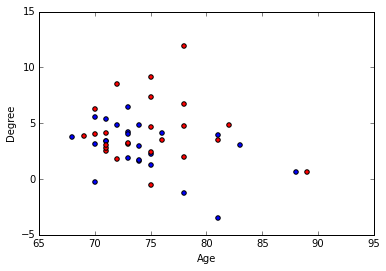

In [87]:
nodes = [0, 3, 10, 34, 38, 52, 57, 77]
reg = 37
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(pos_g.degree(reg, weight='weight'))
    neg_met.append(neg_g.degree(reg, weight='weight'))

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Degree')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

ctx-rh-caudalanteriorcingulate
E4+     r: (-0.52596973881483799, 0.0082929184484989548)
E4-     r: (-0.058338860182976494, 0.7865646997714888)


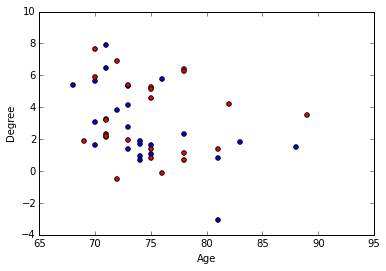

In [89]:
reg = 47
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(pos_g.degree(reg, weight='weight'))
    neg_met.append(neg_g.degree(reg, weight='weight'))

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Degree')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

ctx-rh-inferiortemporal
E4+     r: (0.18583787676968239, 0.38461523568722744)
E4-     r: (0.45914226943759567, 0.024011030716524502)


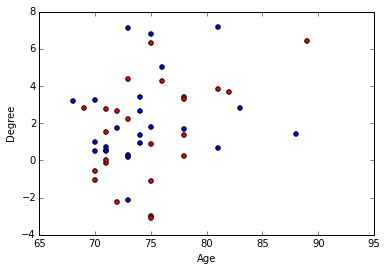

In [90]:
reg = 53
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(pos_g.degree(reg, weight='weight'))
    neg_met.append(neg_g.degree(reg, weight='weight'))

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Degree')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

ctx-rh-parahippocampal
E4+     r: (0.2644037936470659, 0.21183893832167938)
E4-     r: (0.40913184636307987, 0.047122366815432616)


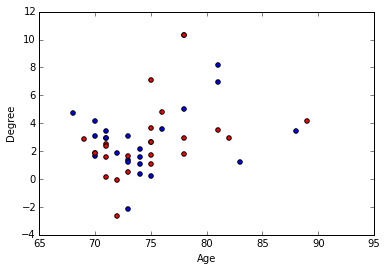

In [91]:
reg = 60
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(pos_g.degree(reg, weight='weight'))
    neg_met.append(neg_g.degree(reg, weight='weight'))

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Degree')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

In [86]:
reg_names = np.genfromtxt('/home/jagust/graph/scripts/fs_gm.csv', delimiter=',', dtype = str)
reg_names = reg_names[:, 0:1]
np.save('/home/jagust/dino/surf/reg_names.npy', reg_names)
def reg_name(reg):
    return str(reg_names[reg][0])

Left-Cerebellum-Cortex
E4+     r: (0.36482438348896812, 0.079627912530122316)
E4-     r: (0.029870063605215127, 0.88980455343905784)


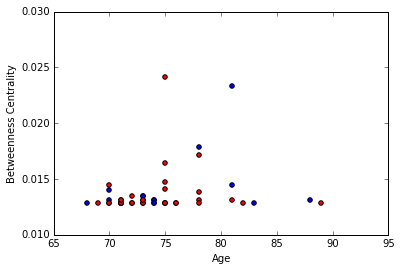

In [106]:
nodes = [0, 3, 10, 34, 38, 52, 57, 77]
reg = 0
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(nx.betweenness_centrality(pos_g, weight='distance').values()[reg])
    neg_met.append(nx.betweenness_centrality(neg_g, weight='distance').values()[reg])

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Betweenness Centrality')
plt.xlabel('Age')
plt.ylim(0.01, 0.03)
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

Left-Putamen
E4+     r: (0.48824243513248783, 0.015494999768556896)
E4-     r: (-0.12739889692299186, 0.55302582375036313)


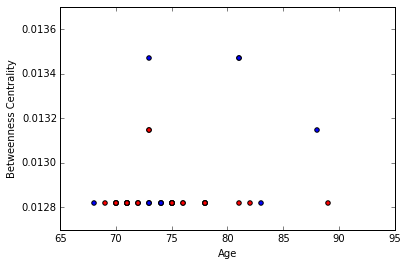

In [113]:
nodes = [0, 3, 10, 34, 38, 52, 57, 77]
reg = 3
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(nx.betweenness_centrality(pos_g, weight='distance').values()[reg])
    neg_met.append(nx.betweenness_centrality(neg_g, weight='distance').values()[reg])

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Betweenness Centrality')
plt.xlabel('Age')
plt.ylim(0.0127, 0.0137)
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0131450827653
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0131450827653
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0128205128205
0.0131450827653
0.0128205128205
0.0128205128205
0.0128205128205
Right-Putamen
E4+     r: (0.39244196410063714, 0.057849862352544225)
E4-     r: (-0.088104500282124479, 0.68226209564182305)


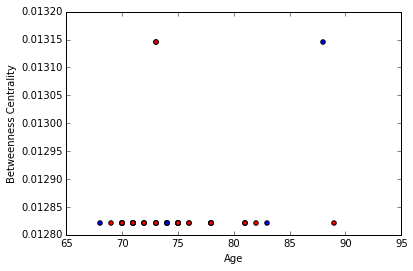

In [116]:
nodes = [0, 3, 10, 34, 38, 52, 57, 77]
reg = 10
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(nx.betweenness_centrality(pos_g, weight='distance').values()[reg])
    neg_met.append(nx.betweenness_centrality(neg_g, weight='distance').values()[reg])

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
for ind in range(len(pos_met)):
    print pos_met[ind]
    print neg_met[ind]
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Betweenness Centrality')
plt.xlabel('Age')
plt.ylim(0.0128, 0.0132)
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

In [102]:
nodes = [0, 3, 10, 34, 38, 52, 57, 77]
reg = 34
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(nx.betweenness_centrality(pos_g, weight='distance').values()[reg])
    neg_met.append(nx.betweenness_centrality(neg_g, weight='distance').values()[reg])

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Betweenness Centrality')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

KeyboardInterrupt: 

In [ ]:
nodes = [0, 3, 10, 34, 38, 52, 57, 77]
reg = 38
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(nx.betweenness_centrality(pos_g, weight='distance').values()[reg])
    neg_met.append(nx.betweenness_centrality(neg_g, weight='distance').values()[reg])

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Betweenness Centrality')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

In [ ]:
nodes = [0, 3, 10, 34, 38, 52, 57, 77]
reg = 52
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(nx.betweenness_centrality(pos_g, weight='distance').values()[reg])
    neg_met.append(nx.betweenness_centrality(neg_g, weight='distance').values()[reg])

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Betweenness Centrality')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

In [ ]:
nodes = [0, 3, 10, 34, 38, 52, 57, 77]
reg = 57
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(nx.betweenness_centrality(pos_g, weight='distance').values()[reg])
    neg_met.append(nx.betweenness_centrality(neg_g, weight='distance').values()[reg])

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Betweenness Centrality')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

In [ ]:
nodes = [0, 3, 10, 34, 38, 52, 57, 77]
reg = 77
pos_age, neg_age, pos_met, neg_met = [], [], [], []
for match in matches:
    pos_id = find_subsess(match[0])
    neg_id = find_subsess(match[1])
    if subject_summary[subject_summary.Subsess == pos_id].values[0][3] < 30:
        continue
    pos_g = load_graph(np.load((match[0])))
    neg_g = load_graph(np.load((match[1])))
    pos_age.append(subject_summary[subject_summary.Subsess == pos_id].values[0][3])
    neg_age.append(subject_summary[subject_summary.Subsess == neg_id].values[0][3])
    pos_met.append(nx.betweenness_centrality(pos_g, weight='distance').values()[reg])
    neg_met.append(nx.betweenness_centrality(neg_g, weight='distance').values()[reg])

rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pos_age, pos_met, c = 'b')
ax.scatter(neg_age, neg_met, c = 'r')
print reg_name(reg)
plt.ylabel('Betweenness Centrality')
plt.xlabel('Age')
rp, rn = stats.pearsonr(pos_age, pos_met), stats.pearsonr(neg_age, neg_met)
print "E4+     r: " + str(rp)
print "E4-     r: " + str(rn)

In [118]:
nx.communicability_centrality_exp(pos_g, weight='distance')

TypeError: communicability_centrality_exp() got an unexpected keyword argument 'weight'